In [ ]:
import numpy as np
import SimpleITK as sitk
import os


path_stochastic = "/scratch/awias/data/nnUNet/nnUNet_raw/Dataset004_TotalSegmentatorPancreas/imagesTs/man_preds_stochastic"
path_deterministic = "/scratch/awias/data/nnUNet/nnUNet_raw/Dataset004_TotalSegmentatorPancreas/imagesTs/man_preds_deterministic"
path_img = "/scratch/awias/data/nnUNet/nnUNet_raw/Dataset004_TotalSegmentatorPancreas/imagesTs"
path_entropy = "/scratch/awias/data/nnUNet/nnUNet_raw/Dataset004_TotalSegmentatorPancreas/imagesTs/entropy" # Output path

os.makedirs(path_entropy, exist_ok=True)

all_subjects = [x.split('_')[0] for x in os.listdir(path_img) if x.endswith('.nii.gz')]

all_subjects = sorted(all_subjects, key=lambda x: int(x))

def entropy(probs):
    # probs: (C,H,W,D)
    eps = 1e-10  # to avoid log(0)
    H = -np.sum(probs * np.log2(probs + eps), axis=0)  # sum over channel dimension
    return H  # shape: (H,W,D)

for subject in all_subjects:
    subject = "77"
    probs_stochastic = np.load(os.path.join(path_stochastic, subject + "_0000_pred.nii.gz.npz"))['probabilities']
    probs_deterministic = np.load(os.path.join(path_deterministic, subject + "_0000_pred.nii.gz.npz"))['probabilities']
    
    entropy_stochastic = entropy(probs_stochastic)
    entropy_deterministic = entropy(probs_deterministic)
    
    diff_entropy = entropy_stochastic - entropy_deterministic # Positive values indicate higher uncertainty in the stochastic model
    
    img_sitk = sitk.ReadImage(os.path.join(path_img, subject + "_0000.nii.gz")) # Only for copying information
    
    entropy_diff_sitk = sitk.GetImageFromArray(diff_entropy)
    entropy_diff_sitk.CopyInformation(img_sitk)
    sitk.WriteImage(entropy_diff_sitk, os.path.join(path_entropy, subject + "_entropy-diff.nii.gz"))

    entropy_stochastic_sitk = sitk.GetImageFromArray(entropy_stochastic)
    entropy_stochastic_sitk.CopyInformation(img_sitk)
    sitk.WriteImage(entropy_stochastic_sitk, os.path.join(path_entropy, subject + "_entropy-stochastic.nii.gz"))

    entropy_deterministic_sitk = sitk.GetImageFromArray(entropy_deterministic)
    entropy_deterministic_sitk.CopyInformation(img_sitk)
    sitk.WriteImage(entropy_deterministic_sitk, os.path.join(path_entropy, subject + "_entropy-deterministic.nii.gz"))
    
    # break

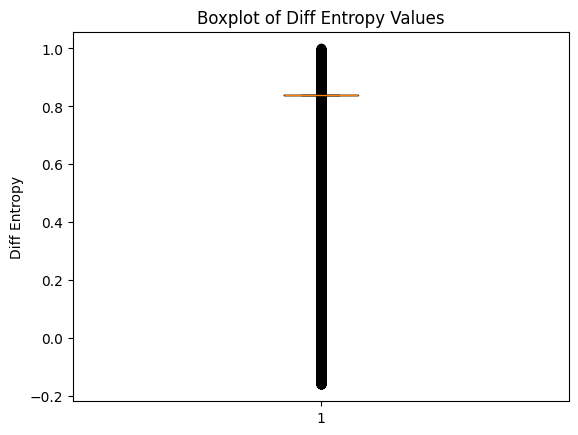

In [ ]:
import matplotlib.pyplot as plt

plt.hist(diff_entropy.flatten(), bins=10)
plt.xlabel('Diff Entropy')
plt.ylabel('Frequency')
plt.title('Histogram of Diff Entropy Values')
plt.show()

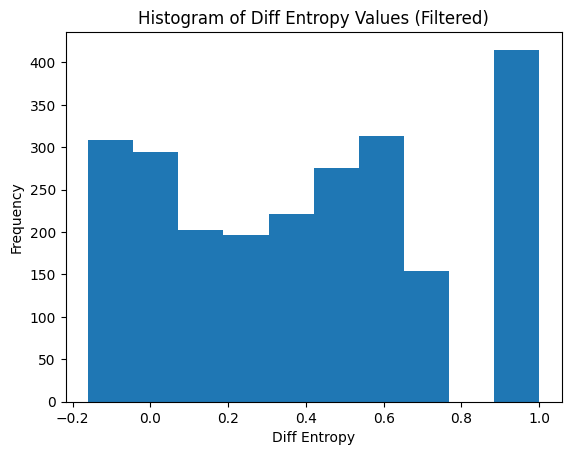

In [32]:
import matplotlib.pyplot as plt

mask = (diff_entropy > 0.9) | (diff_entropy < 0.7)
plt.hist(diff_entropy[mask].flatten(), bins=10)
plt.xlabel('Diff Entropy')
plt.ylabel('Frequency')
plt.title('Histogram of Diff Entropy Values (Filtered)')
plt.show()